In [ ]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path of folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/2024_10_22/'

# Get list of all CSV files in the folder
csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty list to hold the dataframes
dfs = []

# Loop through the CSV files and read each one into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
alarm_data = pd.concat(dfs, ignore_index=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-44-c5d6dd2dd092>:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [ ]:
alarm_data.head()

,Alarm Name,Alarm Source,Alarm ID,Site Name,First Occurred On,Alarm Location Info,Domain,Site ID
0,S1ap Link Down,AKBAR_SGSN,14001,Dummy,2024-10-06 03:14:59,"SubrackNo=4, SlotNo=5, ProcType=SGP, ProcNo=5,...",Core,VV0000
1,S1ap Link Down,PILI_VUSN01,80589,NaN,2024-10-06 03:14:59,"Mobile Country Code=413, Mobile Network Code=0...",Others,NaN
2,RF Unit RX Channel RTWP/RSSI Unbalanced,Rathambale-GM0120-BDGHP,26522,Rathambale,2024-10-06 03:14:59,"Cabinet No.=0, Subrack No.=70, Slot No.=0, Car...",Access,GM0120
3,ALC Controlling Threshold Crossing,Waterfront_B5_Suites_DCU_04-CM2074,28755,Waterfront_Indoor,2024-10-06 03:14:53,"RFA Function Name=RFA_0, Cabinet No.=0, Subrac...",Access,CM2074
4,User Plane Fault,Hangawatta-GM0287-L,25954,Hangawatta,2024-10-06 03:14:44,Service Type=X2,Access,GM0287


Missing values before handling:

Alarm Source                 1
Alarm Name                   0
Alarm ID                     0
Alarm Location Info       1407
Site Name              1537205
First Occurred On            0
Site ID                1523935
Domain                       0
dtype: int64

Missing values after handling:

Alarm Source           0
Alarm Name             0
Alarm ID               0
Alarm Location Info    0
Site Name              0
First Occurred On      0
Site ID                0
Domain                 0
dtype: int64

Shape of data after cleaning: (3253076, 8)

Dataset Summary:
Total number of records: 3253076
Date range: 2024-06-22 09:13:58 to 2024-10-22 09:13:45
Number of unique sites: 4484
Number of unique alarm types: 903

Top 10 Sites by Alarm Frequency:
Site ID
VV0000    590221
CM0091    514409
CM0424    352633
CM2074     24232
CM1275     16585
PO0211     15096
MT0242     13439
CM0002     13102
PU0065     11850
CM1422      8869
Name: count, dtype: int64

Top 10 A

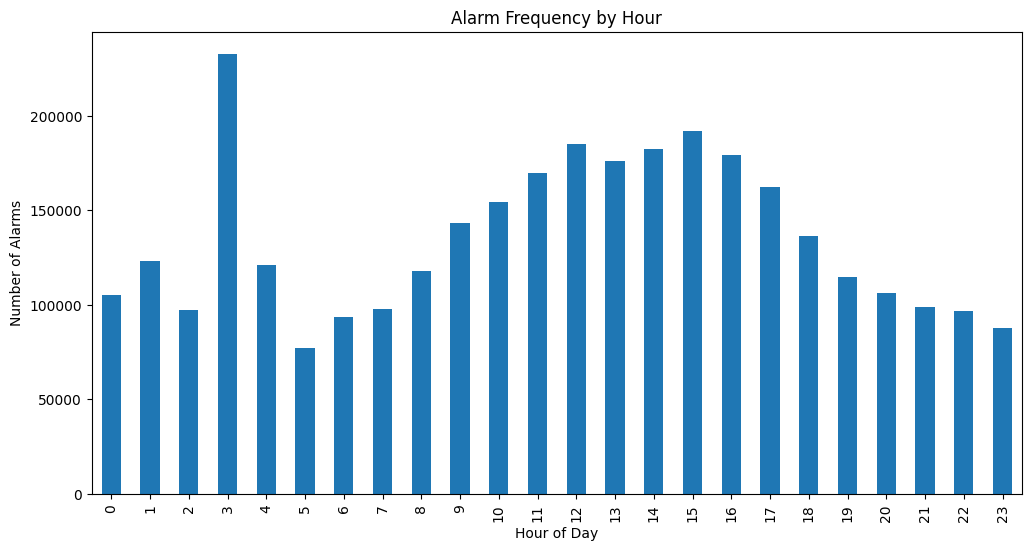

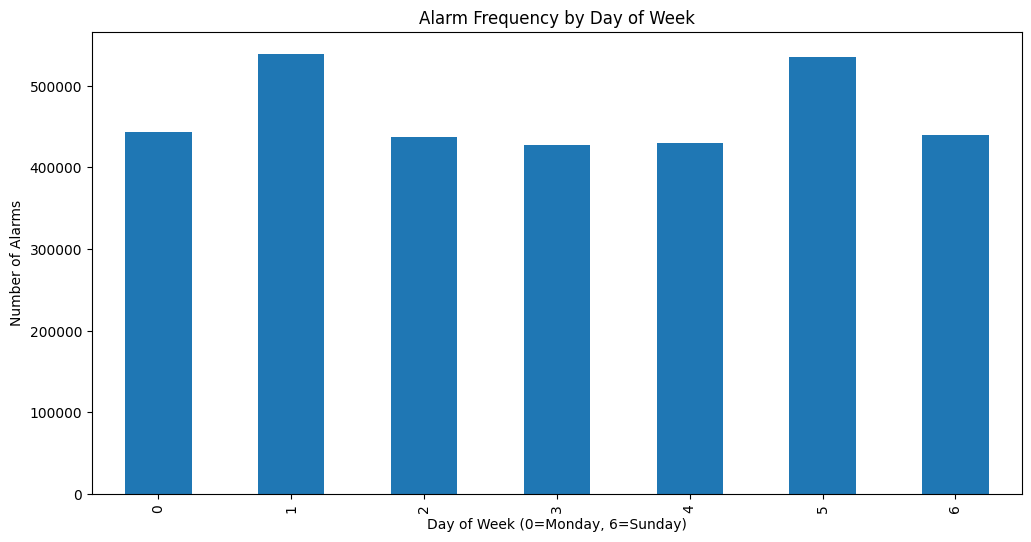


Target Alarm 'RF Unit TX Channel Gain Out of Range' Statistics:
Total occurrences: 4819
Number of affected sites: 185

Top 10 Sites Most Affected by Target Alarm:
Site ID
AM0053    1016
GM0694     408
PO5002     340
GM0177     291
BA5020     239
GM0067     197
CM0121     194
GM0474     190
KU0045     158
CM0445     137
Name: count, dtype: int64


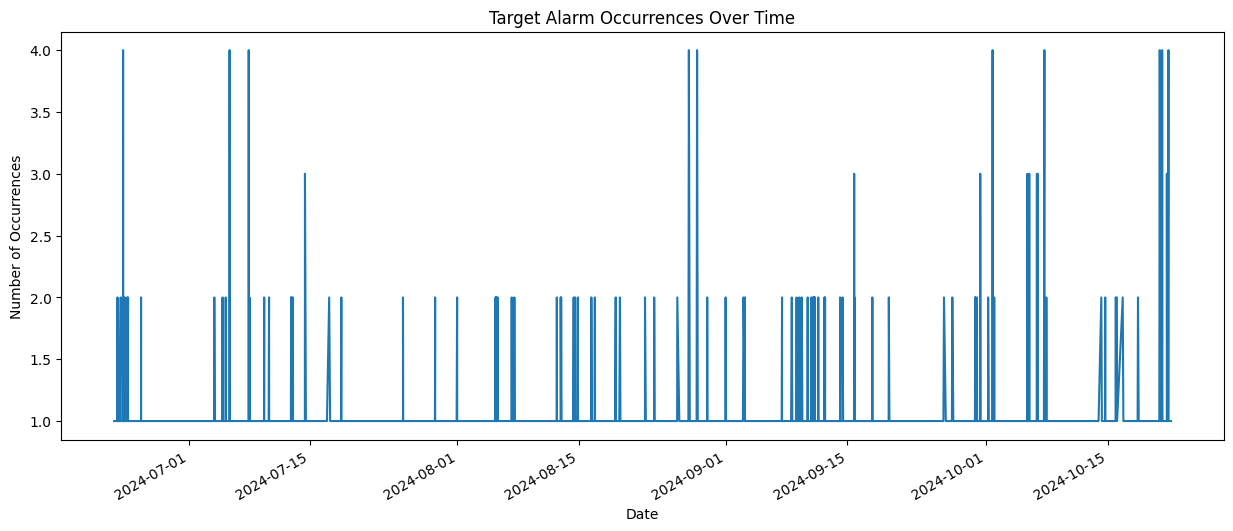

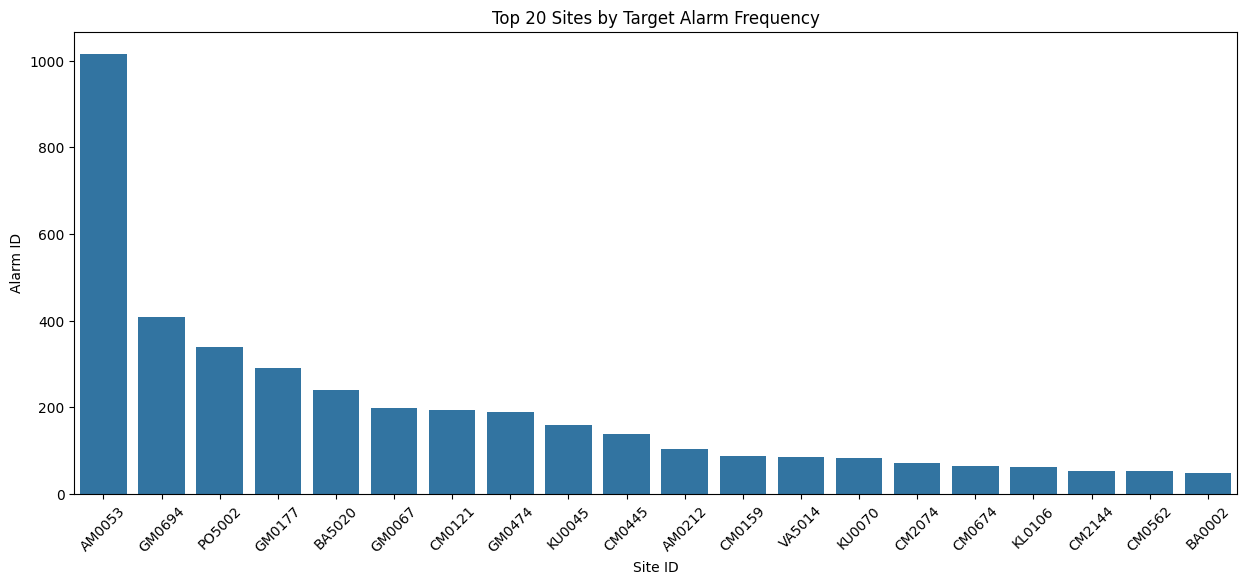


Shape of preprocessed data: (3253076, 12)


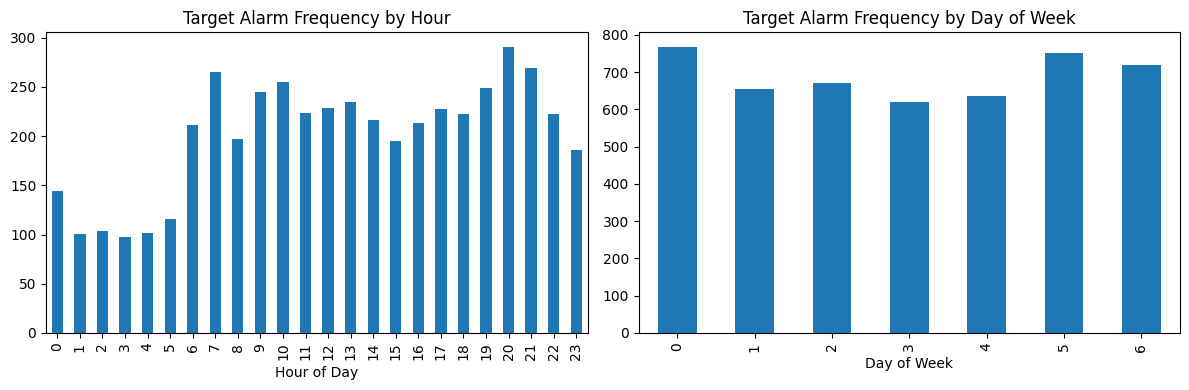

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Select relevant columns
relevant_columns = [
    'Alarm Source', 'Alarm Name', 'Alarm ID',
    'Alarm Location Info', 'Site Name', 'First Occurred On',
    'Site ID', 'Domain'
]
alarm_data = alarm_data[relevant_columns].copy()

# 2. Check initial missing values
print("Missing values before handling:\n")
print(alarm_data.isnull().sum())

# Drop rows with null Site ID and Site Name
alarm_data = alarm_data.dropna(subset=['Site ID', 'Site Name'])

# Drop rows where Site ID is 'VV000'
alarm_data = alarm_data[alarm_data['Site ID'] != 'VV000']

# Handle remaining missing values
alarm_data['Alarm Source'] = alarm_data['Alarm Source'].fillna('Unknown_Source')
alarm_data['Domain'] = alarm_data['Domain'].fillna('Unknown_Domain')
alarm_data['Alarm Location Info'] = alarm_data['Alarm Location Info'].fillna('No_Location_Info')

# Drop rows where critical fields are missing
alarm_data = alarm_data.dropna(subset=['First Occurred On', 'Alarm Name', 'Alarm ID'])

print("\nMissing values after handling:\n")
print(alarm_data.isnull().sum())

# Print the shape of data after cleaning
print("\nShape of data after cleaning:", alarm_data.shape)

# 3. Convert timestamps and create time features
alarm_data['First Occurred On'] = pd.to_datetime(alarm_data['First Occurred On'])
alarm_data = alarm_data.sort_values('First Occurred On')

# Create time-based features
alarm_data['Hour'] = alarm_data['First Occurred On'].dt.hour
alarm_data['Day'] = alarm_data['First Occurred On'].dt.day
alarm_data['DayOfWeek'] = alarm_data['First Occurred On'].dt.dayofweek
alarm_data['Month'] = alarm_data['First Occurred On'].dt.month

# 4. Analyze patterns and create summary
# Basic dataset information
print("\nDataset Summary:")
print(f"Total number of records: {len(alarm_data)}")
print(f"Date range: {alarm_data['First Occurred On'].min()} to {alarm_data['First Occurred On'].max()}")
print(f"Number of unique sites: {alarm_data['Site ID'].nunique()}")
print(f"Number of unique alarm types: {alarm_data['Alarm Name'].nunique()}")

# Analyze alarm patterns
print("\nTop 10 Sites by Alarm Frequency:")
print(alarm_data['Site ID'].value_counts().head(10))

print("\nTop 10 Alarm Types:")
print(alarm_data['Alarm Name'].value_counts().head(10))

# Create visualizations
plt.figure(figsize=(12, 6))
alarm_data.groupby('Hour')['Alarm ID'].count().plot(kind='bar')
plt.title('Alarm Frequency by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Alarms')
plt.show()

plt.figure(figsize=(12, 6))
alarm_data.groupby('DayOfWeek')['Alarm ID'].count().plot(kind='bar')
plt.title('Alarm Frequency by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Alarms')
plt.show()

# 5. Analyze target alarm specifically

target_alarm = "RF Unit TX Channel Gain Out of Range"
target_alarm_data = alarm_data[alarm_data['Alarm Name'] == target_alarm]

print(f"\nTarget Alarm '{target_alarm}' Statistics:")
print(f"Total occurrences: {len(target_alarm_data)}")
print(f"Number of affected sites: {target_alarm_data['Site ID'].nunique()}")

# Show sites most affected by target alarm
print("\nTop 10 Sites Most Affected by Target Alarm:")
print(target_alarm_data['Site ID'].value_counts().head(10))

# Plot target alarm occurrences over time
plt.figure(figsize=(15, 6))
target_alarm_data.groupby('First Occurred On').size().plot()
plt.title('Target Alarm Occurrences Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Occurrences')
plt.show()

# Plot target alarm distribution across sites
plt.figure(figsize=(15, 6))
sns.barplot(x='Site ID', y='Alarm ID', data=target_alarm_data.groupby('Site ID').count().reset_index().sort_values('Alarm ID', ascending=False).head(20))
plt.xticks(rotation=45)
plt.title('Top 20 Sites by Target Alarm Frequency')
plt.show()

# Save preprocessed data
preprocessed_data = alarm_data.copy()
print("\nShape of preprocessed data:", preprocessed_data.shape)

# Additional analysis: Target alarm frequency by hour and day
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
target_alarm_data.groupby('Hour')['Alarm ID'].count().plot(kind='bar')
plt.title('Target Alarm Frequency by Hour')
plt.xlabel('Hour of Day')

plt.subplot(1, 2, 2)
target_alarm_data.groupby('DayOfWeek')['Alarm ID'].count().plot(kind='bar')
plt.title('Target Alarm Frequency by Day of Week')
plt.xlabel('Day of Week')
plt.tight_layout()
plt.show()

In [ ]:
# prompt: plot target alarm occurence for each sites x is date and y is alarm id  , plot each site seperately, use a dot plot

# Assuming target_alarm_data is already defined as in your previous code

# Group data by Site Name and then plot for each site
for site_name in target_alarm_data['Site Name'].unique():
  site_data = target_alarm_data[target_alarm_data['Site Name'] == site_name]
  if not site_data.empty:
    plt.figure(figsize=(12, 6))
    plt.scatter(site_data['First Occurred On'], site_data['Alarm ID'], marker='o')
    plt.title(f'Target Alarm Occurrences for Site: {site_name}')
    plt.xlabel('Date')
    plt.ylabel('Alarm ID')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# prompt: get the alarms within previous 7 days before the each target alarm  for each site ids, and plot them in red , seperately for site ids  on the above plots

# Assuming target_alarm_data is already defined as in your previous code

# Group data by Site Name and then plot for each site
for site_name in target_alarm_data['Site Name'].unique():
  site_data = target_alarm_data[target_alarm_data['Site Name'] == site_name]
  if not site_data.empty:
    plt.figure(figsize=(12, 6))

    # Plot target alarm occurrences
    plt.scatter(site_data['First Occurred On'], site_data['Alarm ID'], marker='o')

    # Get alarms within previous 7 days for each target alarm
    for index, row in site_data.iterrows():
      target_alarm_time = row['First Occurred On']
      previous_week_time = target_alarm_time - pd.Timedelta(days=7)
      alarms_within_week = alarm_data[(alarm_data['Site Name'] == site_name) &
                                     (alarm_data['First Occurred On'] >= previous_week_time) &
                                     (alarm_data['First Occurred On'] < target_alarm_time)]
      if not alarms_within_week.empty:
        plt.scatter(alarms_within_week['First Occurred On'], alarms_within_week['Alarm ID'], color='red', marker='x')

    plt.title(f'Target Alarm Occurrences for Site: {site_name}')
    plt.xlabel('Date')
    plt.ylabel('Alarm ID')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# prompt: print the most common pattern

from collections import Counter

def most_common_pattern(filename="filename.txt"):
    try:
        with open(filename, 'r') as file:
            content = file.read()
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return

    # Remove comments and empty lines, then split into words
    lines = [line for line in content.split('\n') if line and not line.strip().startswith('#')]
    words = ' '.join(lines).split()

    # Count word frequencies
    word_counts = Counter(words)

    # Find the most common word
    most_common_word, count = word_counts.most_common(1)[0]

    print(f"The most common pattern is: '{most_common_word}' (appears {count} times)")


most_common_pattern()

<ipython-input-48-bde6dd9c3ee2>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=relationship_df.head(20), x='Count', y='Alarm ID', palette='viridis')


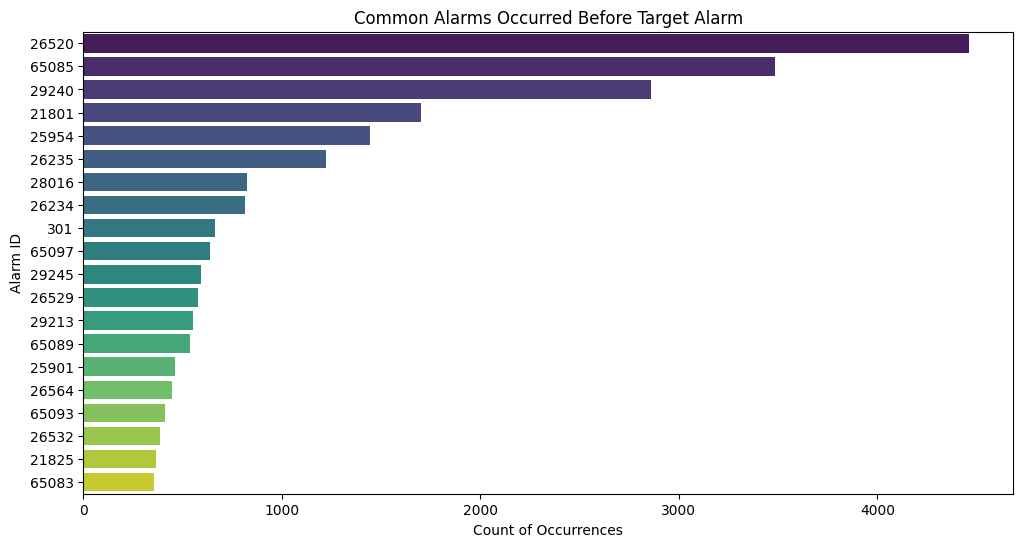

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# print ("hello")
# Assuming target_alarm_data and alarm_data are defined as in your previous code

# Create a dictionary to store the alarms before each target alarm
alarm_relationships = {}

# Iterate through each target alarm occurrence
for index, target_row in target_alarm_data.iterrows():
    target_alarm_time = target_row['First Occurred On']
    site_id = target_row['Site ID']

    # Find alarms within the previous 7 days
    previous_week_time = target_alarm_time - pd.Timedelta(days=7)
    prior_alarms = alarm_data[(alarm_data['Site ID'] == site_id) &
                              (alarm_data['First Occurred On'] >= previous_week_time) &
                              (alarm_data['First Occurred On'] < target_alarm_time)]

    # Count unique alarm IDs
    for alarm_id in prior_alarms['Alarm ID'].unique():
        if alarm_id not in alarm_relationships:
            alarm_relationships[alarm_id] = 0
        alarm_relationships[alarm_id] += 1

# Convert the dictionary to a DataFrame for visualization
relationship_df = pd.DataFrame(list(alarm_relationships.items()), columns=['Alarm ID', 'Count'])
relationship_df = relationship_df.sort_values(by='Count', ascending=False)

# Plotting the relationships
plt.figure(figsize=(12, 6))
sns.barplot(data=relationship_df.head(20), x='Count', y='Alarm ID', palette='viridis')
plt.title('Common Alarms Occurred Before Target Alarm')
plt.xlabel('Count of Occurrences')
plt.ylabel('Alarm ID')
plt.show()

<ipython-input-80-8465f7224427>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=relationship_df.head(20), x='Count', y='Alarm Name', palette='viridis')


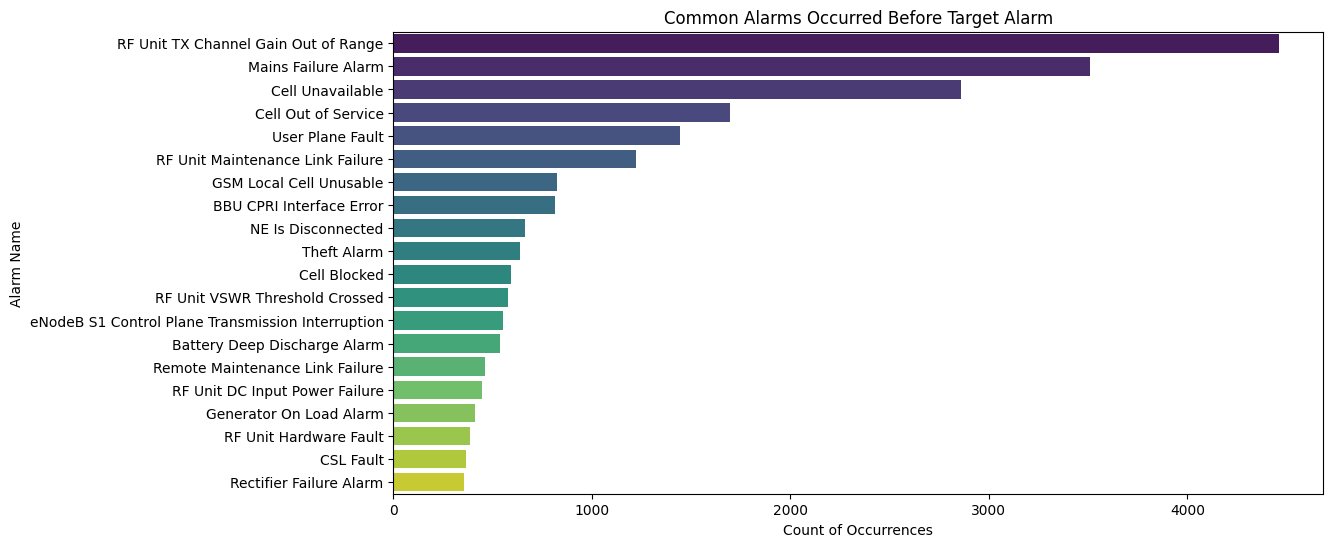

In [ ]:
# prompt: map the labels in above graph with actual names

# Assuming target_alarm_data and alarm_data are defined as in your previous code

# Create a dictionary to store the alarms before each target alarm
alarm_relationships = {}

# Iterate through each target alarm occurrence
for index, target_row in target_alarm_data.iterrows():
    target_alarm_time = target_row['First Occurred On']
    site_id = target_row['Site ID']

    # Find alarms within the previous 7 days
    previous_week_time = target_alarm_time - pd.Timedelta(days=7)
    prior_alarms = alarm_data[(alarm_data['Site ID'] == site_id) &
                              (alarm_data['First Occurred On'] >= previous_week_time) &
                              (alarm_data['First Occurred On'] < target_alarm_time)]

    # Store alarm names and their counts
    for alarm_name in prior_alarms['Alarm Name'].unique():
        if alarm_name not in alarm_relationships:
            alarm_relationships[alarm_name] = 0
        alarm_relationships[alarm_name] += 1

# Convert the dictionary to a DataFrame for visualization
relationship_df = pd.DataFrame(list(alarm_relationships.items()), columns=['Alarm Name', 'Count'])
relationship_df = relationship_df.sort_values(by='Count', ascending=False)

# Plotting the relationships
plt.figure(figsize=(12, 6))
sns.barplot(data=relationship_df.head(20), x='Count', y='Alarm Name', palette='viridis')
plt.title('Common Alarms Occurred Before Target Alarm')
plt.xlabel('Count of Occurrences')
plt.ylabel('Alarm Name')
plt.show()

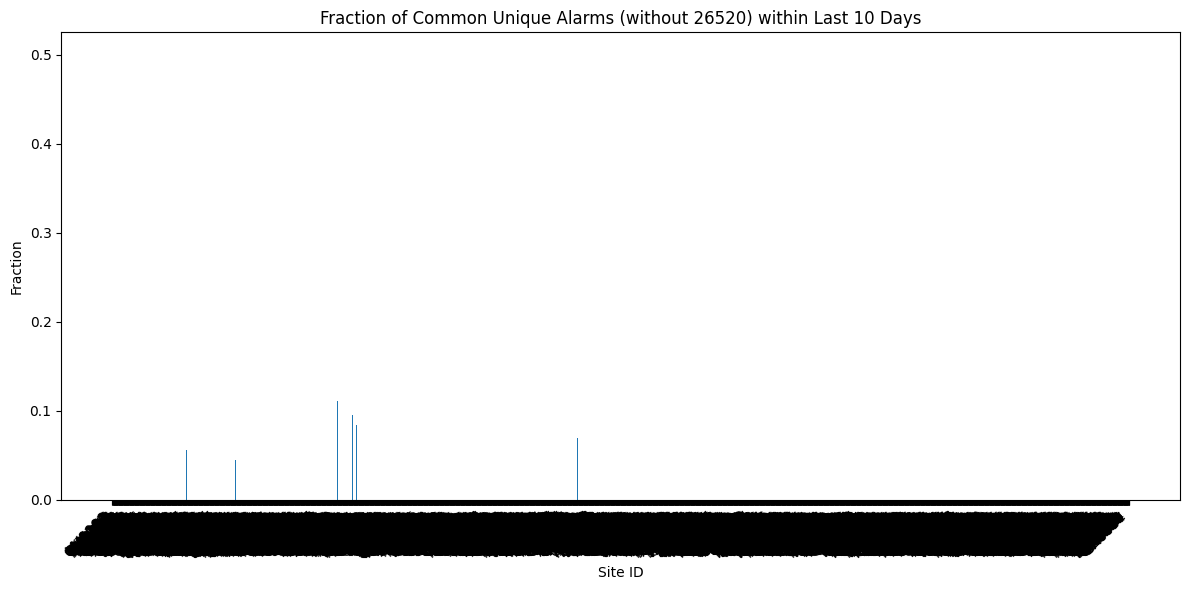

In [ ]:
# prompt: lets consider the last 10 day data from initial dataset. check site id wise last 10 day alarms . fraction =  alarms came to that site id which are equal to {Common unique Alarms Occurred Before Target Alarm without 26520} / all alarms for that site id within that 10 days.plot a graph with x axis  is site ids and y axis fraction , use unique alarm ids only  , without considering alarm id 26520

# Assuming target_alarm_data and alarm_data are defined as in your previous code

# Get the last 10 days of data
last_10_days_data = alarm_data[alarm_data['First Occurred On'] >= (alarm_data['First Occurred On'].max() - pd.Timedelta(days=10))]

# Create a dictionary to store the fraction of alarms for each site ID
site_fraction_dict = {}

# Iterate through unique site IDs
for site_id in last_10_days_data['Site ID'].unique():
  site_data = last_10_days_data[last_10_days_data['Site ID'] == site_id]
  total_alarms_site = len(site_data)

  if total_alarms_site > 0:
      # Filter alarms without 26520
      site_alarms_without_26520 = site_data[site_data['Alarm ID'] != 26520]

      # Find unique alarms occurred before target alarms within the last 10 days
      unique_alarms_before_target = []
      for index, row in target_alarm_data[target_alarm_data['Site ID'] == site_id].iterrows():
          target_alarm_time = row['First Occurred On']
          previous_10_days_time = target_alarm_time - pd.Timedelta(days=10)

          prior_alarms = site_alarms_without_26520[(site_alarms_without_26520['First Occurred On'] >= previous_10_days_time) &
                                             (site_alarms_without_26520['First Occurred On'] < target_alarm_time)]

          for alarm_id in prior_alarms['Alarm ID'].unique():
              if alarm_id not in unique_alarms_before_target:
                  unique_alarms_before_target.append(alarm_id)

      # Calculate fraction
      if len(unique_alarms_before_target) > 0:
        fraction = len(unique_alarms_before_target) / total_alarms_site
      else:
        fraction = 0
      site_fraction_dict[site_id] = fraction

# Create a DataFrame from the dictionary
fraction_df = pd.DataFrame(list(site_fraction_dict.items()), columns=['Site ID', 'Fraction'])

# Plot the graph
plt.figure(figsize=(12, 6))
plt.bar(fraction_df['Site ID'], fraction_df['Fraction'])
plt.xlabel('Site ID')
plt.ylabel('Fraction')
plt.title('Fraction of Common Unique Alarms (without 26520) within Last 10 Days')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [ ]:
# prompt: print above site ids with fraction >0.2 with the fraction

# Assuming fraction_df is defined as in your previous code

# Filter sites with fraction > 0.2
filtered_fraction_df = fraction_df[fraction_df['Fraction'] > 0.2]

# Print Site IDs and their corresponding fractions
for index, row in filtered_fraction_df.iterrows():
  print(f"Site ID: {row['Site ID']}, Fraction: {row['Fraction']}")

Site ID: CM0378, Fraction: 0.5
Site ID: KU0008, Fraction: 0.39473684210526316
Site ID: CM2344, Fraction: 0.20238095238095238
Site ID: KU0065, Fraction: 0.42857142857142855
Site ID: CM0133, Fraction: 0.2777777777777778
Site ID: CM0567, Fraction: 0.3333333333333333
